<a href="https://colab.research.google.com/github/TimeIsTheChoice/ColabCaffe/blob/master/00_classification_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Caffe prepare

In [0]:
#!apt-get -y install caffe-cuda
!apt-get -y install caffe-cpu
!git clone https://github.com/TimeIsTheChoice/caffe.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  caffe-tools-cpu cython3 fonts-lyx javascript-common libblosc1 libcaffe-cpu1
  libgflags2.2 libgoogle-glog0v5 libjs-jquery libjs-jquery-ui libleveldb1v5
  liblmdb0 python-matplotlib-data python-tables-data python3-bs4
  python3-caffe-cpu python3-chardet python3-cycler python3-dateutil
  python3-decorator python3-gflags python3-h5py python3-html5lib
  python3-ipython python3-ipython-genutils python3-leveldb python3-lxml
  python3-matplotlib python3-networkx python3-nose python3-numexpr
  python3-olefile python3-pandas python3-pandas-lib python3-pexpect
  python3-pickleshare python3-pil python3-pkg-resources python3-prompt-toolkit
  python3-protobuf python3-ptyprocess python3-pygments python3-pyparsing
  python3-pywt python3-scipy python3-simplegeneric python3-six python3-skimage
  python3-skimage-lib python3-tables python3-tables-lib pytho

### Error rectify 


> you must adjust this file to correct the error will encounter!



####**1.TypeError: _open() got an unexpected keyword argument 'as_grey'**

alter 


> /usr/local/lib/python3.6/dist-packages/skimage/io/_io.py 



```
img = skimage.img_as_float(skimage.io.imread(filename, as_grey=not color)).astype(np.float32)
```
to
```
img = skimage.img_as_float(skimage.io.imread(filename, as_gray=not color)).astype(np.float32)
```
pycaffe depends on skimage to do image preprocessing. As skimage moved forward in versions, they decided to rename some function argument from as_grey to as_gray.

In [0]:
!cp /content/caffe/python/caffe/io.py /usr/lib/python3/dist-packages/caffe/io.py #alter by Yuhang's rectified code

#### 2.restart


In [0]:
import os
os.kill(os.getpid(), 9)


>verify pycaffe 



In [1]:
import os
import caffe

dir_name = '/content/caffe'
caffe_root='/content/caffe/'
os.chdir(dir_name) # change directory from working dir to dir with files
print("import successful!")

import successful!


### 1.Setup

* First, set up Python, `numpy`, and `matplotlib`.
* [matplotlib configure file](https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files)

In [0]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print ('CaffeNet found.')
else:
    print('Downloading pre-trained CaffeNet model...')
    !./scripts/download_model_binary.py ./models/bvlc_reference_caffenet

...100%, 232 MB, 30920 KB/s, 7 seconds passed

### 2.Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [0]:
model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'# load caffe test net
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'#load trained weight

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print ('mean-subtracted values:',[x for x in zip('BGR', mu)])


# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR.OpenCV read image in RGB colour format.

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3.CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [0]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.



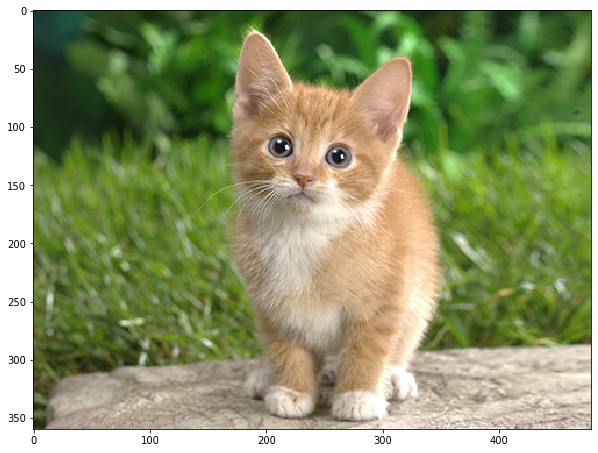

In [7]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

* Adorable! Let's classify it!

In [0]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

#the shape of output['prob'] is (50,1000),50 is match with the batch size and 1000 represent 1000 kind of multi-classification 
output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
print('predicted class is:', output_prob.argmax())

predicted class is: 281


* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

In [0]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !./data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print('output label:', labels[output_prob.argmax()])

output label: n02123045 tabby, tabby cat


* "Tabby cat" is correct! But let's also look at other top (but less confident predictions).
* output top5-error
>the top-5 error rate is the fraction of test images for which the correct label
is not among the five labels considered most probable by the model

In [0]:
# sort top five predictions from softmax output
#slice(start, stop, step) [::-1]:reverse sort 
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items
probabilities=zip(output_prob[top_inds], labels[top_inds])#The zip() function takes iterables (can be zero or more), aggregates them in a tuple, and return it.
print('probabilities and labels:')
for item in probabilities:
  print(item)

probabilities and labels:
(0.3292994, 'n02123045 tabby, tabby cat')
(0.2345552, 'n02123159 tiger cat')
(0.12841488, 'n02124075 Egyptian cat')
(0.10342465, 'n02119022 red fox, Vulpes vulpes')
(0.062001817, 'n02127052 lynx, catamount')


* We see that less confident predictions are sensible.

In [0]:
%timeit net.forward()

1 loop, best of 3: 2.3 s per loop


### 4.Switching to GPU mode(unuseful)

* Let's see how long classification took, and compare it to GPU mode.
* May got crash!!!

In [0]:
%timeit net.forward()

1 loop, best of 3: 1.42 s per loop


* That's a while, even for a batch of 50 images. Let's switch to GPU mode.

In [0]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

* That should be much faster!

### 5.Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

* First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form 
```
(batch_size, channel_dim, height, width)
```

*    The activations are exposed as an `OrderedDict`, `net.blobs`.





In [0]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.items():
    print (layer_name + '\t' + str(blob.data.shape))

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. 
* We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form 
    ```
    (output_channels, input_channels, filter_height, filter_width)
    ``` 
(for the weights)    
 and the 1-dimensional shape 

    ```
    (output_channels,)
    ````
     (for the biases).

In [0]:
for layer_name, param in net.params.items():
    print (layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape))

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [0]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('on')

#### First we'll look at the first layer filters, `conv1`

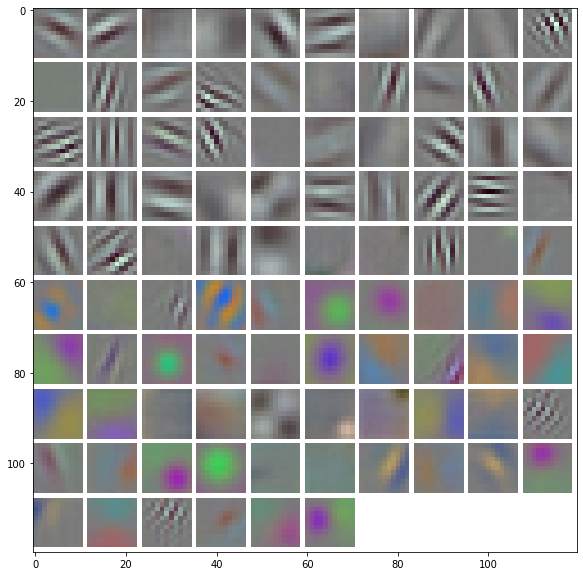

In [0]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
#the output is 96 filters,each square is a filter
#match with conv1	(96, 3, 11, 11) (96,)
vis_square(filters.transpose(0, 2, 3, 1))#(n, 3,height, width) to (n, height, width, 3)

#### The first layer output, `conv1`
> (rectified responses of the filters above, first 36 only)

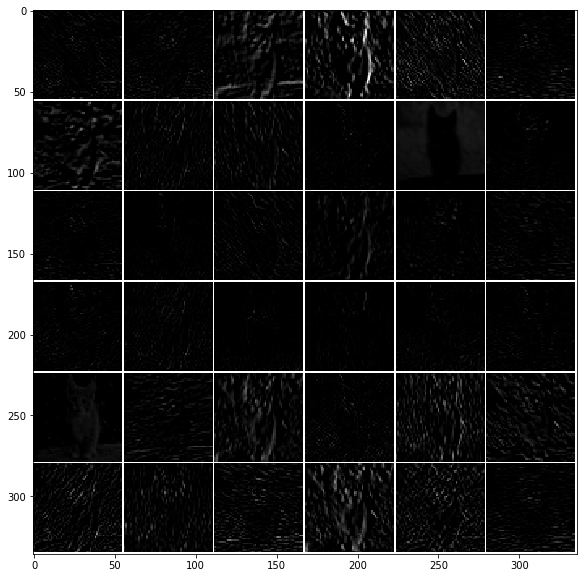

In [0]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

#### The fifth layer after pooling, `pool5`

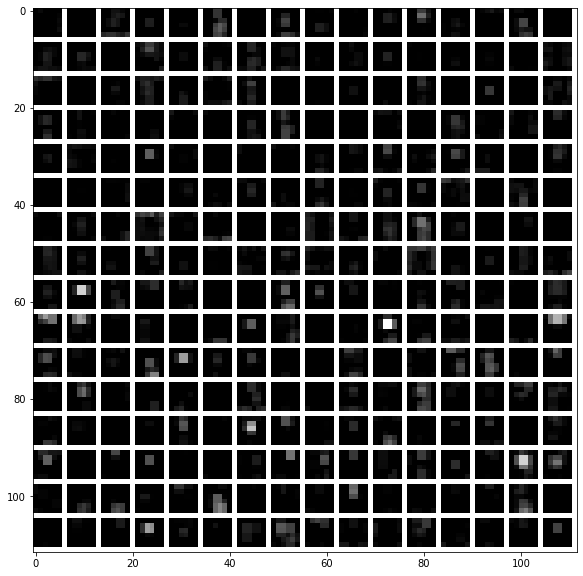

In [0]:
feat = net.blobs['pool5'].data[0]
#pool5	(50, 256, 6, 6) x:16 y:16
vis_square(feat)

#### The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

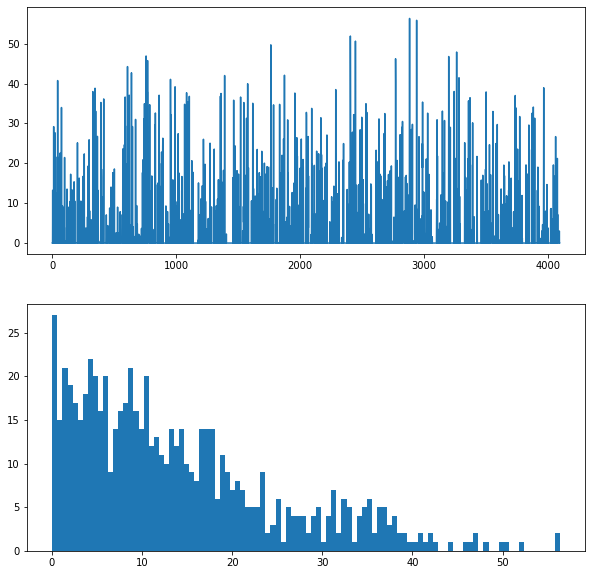

In [0]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

#### The final probability output, `prob`

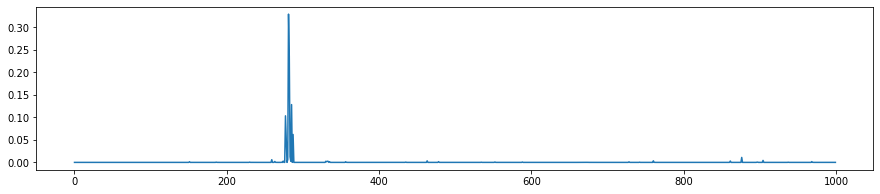

In [0]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

--2020-03-31 05:37:08--  https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443340 (1.4M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.38M  3.58MB/s    in 0.4s    

2020-03-31 05:37:09 (3.58 MB/s) - ‘image.jpg’ saved [1443340/1443340]

probabilities and labels:
(0.96752095, 'n02480495 orangutan, orang, orangutang, Pongo pygmaeus')
(0.031655576, 'n02492660 howler monkey, howler')
(0.0004016191, 'n02493509 titi, titi monkey')
(0.000119585726, 'n02493793 spider monkey, Ateles geoffroyi')
(6.4349566e-05, 'n02488291 langur')


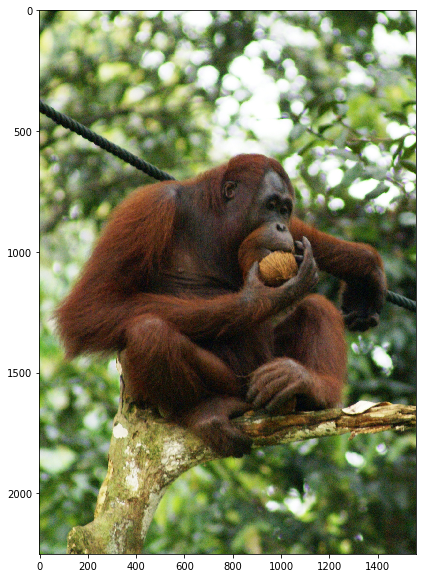

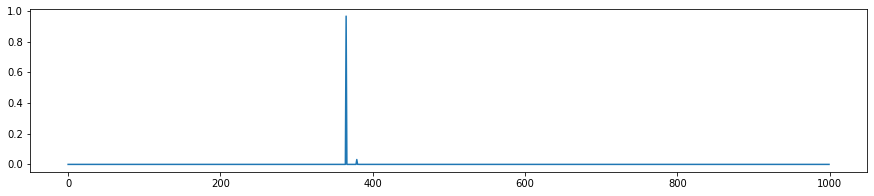

In [0]:
# download an image
my_image_url = "..."  # paste your URL here
# for example:
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

plt.figure(figsize=(15, 3))
plt.plot(output_prob.flat)

print ('probabilities and labels:')
for item in zip(output_prob[top_inds], labels[top_inds]):
  print(item)